In [1]:
import seagul.envs
import gym

env = gym.make('su_acro_drake-v0')

import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import torch

/home/sgillen/work/seagul/seagul/envs/__init__.py:88: UserWarning: Warning, registering environments for rllib failed!
  warnings.warn("Warning, registering environments for rllib failed!")


total 0.058536529541015625
[0.]


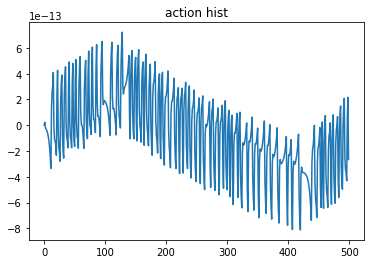

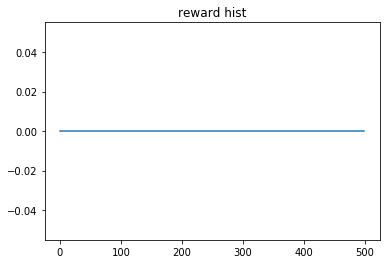

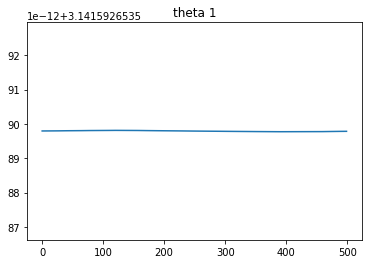

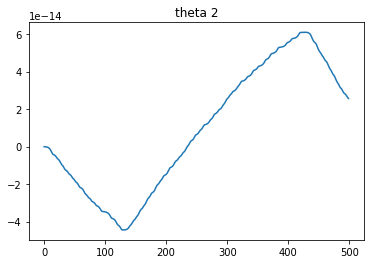

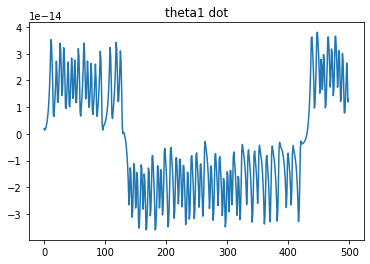

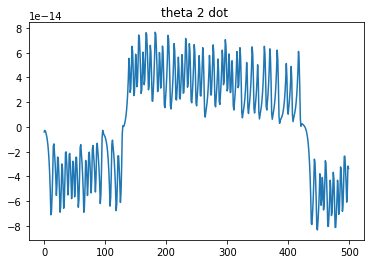

In [4]:
env = gym.make('su_acro_drake-v0', init_state=[pi,0,0,0], reward_fn = lambda x:0)

#env = gym.make('sg_cartpole-v0')

env.num_steps = 500

def control(q):
    k =  np.array([1316.85, 555.42, 570.33, 272.58])
    #k = np.array([[278.44223126, 112.29125985, 119.72457377,  56.82824017]])
    #k = np.array([[10.44, 3.561, 2.778, 1.301]])
    #k = 
    #import ipdb; ipdb.set_trace()
    gs = np.array([pi,0,0,0])
    #return 0
    return -k.dot(gs - q)

action_hist = np.zeros((env.num_steps,1))
state_hist = np.zeros((env.num_steps, env.observation_space.shape[0]))
reward_hist = np.zeros((env.num_steps, 1))
obs = env.reset() 

import time
start = time.time()
for i in range(env.num_steps):
        actions = np.clip(np.asarray(control(obs)), -10,10)
        obs, reward, done, _ = env.step(actions)
        action_hist[i,:] = np.copy(actions)
        state_hist[i,:] = np.copy(obs)
        reward_hist[i,:] = np.copy(reward)
       # if done:
       #     break
            
print("total", time.time() - start)

plt.plot(action_hist)
plt.title('action hist')

plt.figure()
plt.plot(reward_hist)
plt.title('reward hist')

plt.figure()
plt.plot(state_hist[:,0])
plt.title("theta 1")

plt.figure()
plt.plot(state_hist[:,1])
plt.title("theta 2")

plt.figure()
plt.plot(state_hist[:,2])
plt.title("theta1 dot")

plt.figure()
plt.plot(state_hist[:,3])
plt.title("theta 2 dot ")

print(sum(reward_hist))

In [54]:
env = gym.make('su_acro_drake-v0')
env.num_steps = 500

def control(q):
    #k =  np.array([1316.85, 555.42, 570.33, 272.58])
    k = np.array([[278.44223126, 112.29125985, 119.72457377,  56.82824017]])
    #k = np.array([[10.44, 3.561, 2.778, 1.301]])
    #import ipdb; ipdb.set_trace()
    gs = np.array([pi,0,0,0])
    #return 0
    return -k.dot(gs - q)

action_hist = np.zeros((env.num_steps,1))
state_hist = np.zeros((env.num_steps, env.observation_space.shape[0]))
reward_hist = np.zeros((env.num_steps, 1))
obs = env.reset(init_vec = [.01,0,0,0]) 

th1_min = pi-1; th1_max = pi+1; num_th1 = 40
th1_vals = np.linspace(th1_min, th1_max, num_th1)

th2_min = -2; th2_max = 2; num_th2 = 40
th2_vals = np.linspace(th2_min, th2_max, num_th2)

th1dot_min = -.5; th1dot_max = .5; num_th1dot = 1
th1dot_vals = np.linspace(th1dot_min, th1dot_max, num_th1dot)
#th1dot_vals = np.zeros(1)

th2dot_min = -.5; th2dot_max = .5; num_th2dot = 1
th2dot_vals = np.linspace(th2dot_min, th2dot_max, num_th2dot)
#th2dot_vals = np.zeros(1)




results = np.zeros((th1_vals.size, th2_vals.size, th1dot_vals.size, th2dot_vals.size))
rewards = np.zeros((th1_vals.size, th2_vals.size, th1dot_vals.size, th2dot_vals.size))


import time
start = time.time()

for th1_i, th1 in enumerate(th1_vals):
    for th2_i, th2 in enumerate(th2_vals):
        obs = env.reset(init_vec = [th1, th2, 0, 0])
        for i in range(env.num_steps):
            actions = np.clip(np.asarray(control(obs)), -25, 25)
            obs, reward, done, _ = env.step(actions)
            action_hist[i,:] = np.copy(actions)
            state_hist[i,:] = np.copy(obs)
            reward_hist[i,:] = np.copy(reward)
            
        results[th1_i, th2_i,0,0] = sum(reward_hist) > 900
        rewards[th1_i, th2_i,0,0] = sum(reward_hist)
       
end = time.time()
print(end - start)


386.35410046577454


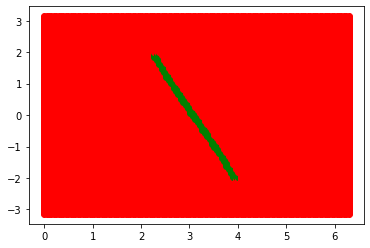

In [4]:
# Print neural net predicted agility map
for i,ival in enumerate(results[:,:,0,0]):
    for j,val in enumerate(ival):
            if val:
                plt.plot(th1_vals[i], th2_vals[j], 'o', color = 'green')
            else:
                plt.plot(th1_vals[i], th2_vals[j], 'o', color='red')
          

In [134]:
env = gym.make('su_acro_drake-v0')
env.num_steps = 500

slope = -2.1111111111111116 #empirically determined from the above

def control(q):
    k =  np.array([1316.85, 555.42, 570.33, 272.58])
    #k = np.array([[278.44223126, 112.29125985, 119.72457377,  56.82824017]])
    #k = np.array([[10.44, 3.561, 2.778, 1.301]])
    #import ipdb; ipdb.set_trace()
    gs = np.array([pi,0,0,0])
    #return 0
    return -k.dot(gs - q)

action_hist = np.zeros((env.num_steps,1))
state_hist = np.zeros((env.num_steps, env.observation_space.shape[0]))
reward_hist = np.zeros((env.num_steps, 1))
obs = env.reset(init_vec = [.01,0,0,0]) 

th1_min = pi-.5; th1_max = pi+.5; num_th1 = 10
th1_vals = np.linspace(th1_min, th1_max, num_th1)

th1dot_min = -5; th1dot_max = 5; num_th1dot = 15
th1dot_vals = np.linspace(th1dot_min, th1dot_max, num_th1dot)
#th1dot_vals = np.zeros(1)

th2dot_min = -15; th2dot_max = 15; num_th2dot = 15
th2dot_vals = np.linspace(th2dot_min, th2dot_max, num_th2dot)
#th2dot_vals = np.zeros(1)


results = np.zeros((th1_vals.size, 1, th1dot_vals.size, th2dot_vals.size))
rewards = np.zeros((th1_vals.size, 1, th1dot_vals.size, th2dot_vals.size))

import time
start = time.time()

for th1_i, th1 in enumerate(th1_vals):
    for th1dot_i, th1dot in enumerate(th1dot_vals):
            for th2dot_i, th2dot in enumerate(th2dot_vals):
                obs = env.reset(init_vec = [th1, slope*(th1-pi), th1dot, th2dot])
                for i in range(env.num_steps):
                    actions = np.clip(np.asarray(control(obs)), -25,25)
                    obs, reward, done, _ = env.step(actions)
                    action_hist[i,:] = np.copy(actions)
                    state_hist[i,:] = np.copy(obs)
                    reward_hist[i,:] = np.copy(reward)

                results[th1_i, 0, th1dot_i, th2dot_i] = sum(reward_hist) > 900
                rewards[th1_i, 0, th1dot_i, th2dot_i] = sum(reward_hist)

end = time.time()
print(end - start)



484.0542016029358


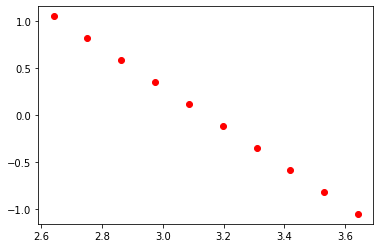

In [105]:
for i,ival in enumerate(results[:,:,5,10]):
    for j,val in enumerate(ival):
            if val:
                plt.plot(th1_vals[i], slope*(th1_vals[i]-pi), 'o', color = 'green')
            else:
                plt.plot(th1_vals[i], slope*(th1_vals[i]-pi), 'o', color='red')
          

In [133]:
for i,ival in enumerate(results[0,0,:,:]):
    for j,val in enumerate(ival):
            if val:
                plt.plot(th1dot_vals[i], th2dot_vals[j], 'o', color = 'green')
            else:
                plt.plot(th1dot_vals[i], th2dot_vals[j], 'o', color='red')

In [4]:
env = gym.make('su_acro_drake-v0')
env.num_steps = 500

def control(q):
    k =  np.array([1316.85, 555.42, 570.33, 272.58])
    #k = np.array([[278.44223126, 112.29125985, 119.72457377,  56.82824017]])
    #k = np.array([[10.44, 3.561, 2.778, 1.301]])
    #import ipdb; ipdb.set_trace()
    gs = np.array([pi,0,0,0])
    #return 0
    return -k.dot(gs - q)

action_hist = np.zeros((env.num_steps,1))
state_hist = np.zeros((env.num_steps, env.observation_space.shape[0]))
reward_hist = np.zeros((env.num_steps, 1))
obs = env.reset(init_vec = [0,0,0,0]) 

th1_min = 0; th1_max = 2*pi; num_th1 = 64
th1_vals = np.linspace(th1_min, th1_max, num_th1)

th2_min = -pi; th2_max = pi; num_th2 = 64
th2_vals = np.linspace(th2_min, th2_max, num_th2)

th1dot_min = -1; th1dot_max = 1; num_th1dot = 3
th1dot_vals = np.linspace(th1dot_min, th1dot_max, num_th1dot)
#th1dot_vals = np.zeros(1)

th2dot_min = -1; th2dot_max = 1; num_th2dot = 3
th2dot_vals = np.linspace(th2dot_min, th2dot_max, num_th2dot)
#th2dot_vals = np.zeros(1)


th1_eval_min = pi-1; th1_eval_max = pi+1
th2_eval_min = -2; th2_eval_max = 2

results = np.zeros((th1_vals.size, th2_vals.size, th1dot_vals.size, th2dot_vals.size))
rewards = np.zeros((th1_vals.size, th2_vals.size, th1dot_vals.size, th2dot_vals.size))


import time
start = time.time()

in_count = out_count = 0
for th1_i, th1 in enumerate(th1_vals):
    for th2_i, th2 in enumerate(th2_vals):
        for th1dot in th1dot_vals:
            for th2dot in th2dot_vals:
                in_count += 1
                if th1_eval_min < th1 < th1_eval_max and th2_eval_min < th2 < th2_eval_max and th1dot == 0 and th2dot == 0:
                    obs = env.reset(init_vec = [th1, th2, 0, 0])
                    for i in range(env.num_steps):
                        actions = np.clip(np.asarray(control(obs)), -25, 25)
                        obs, reward, done, _ = env.step(actions)
                        action_hist[i,:] = np.copy(actions)
                        state_hist[i,:] = np.copy(obs)
                        reward_hist[i,:] = np.copy(reward)


                    results[th1_i, th2_i,0,0] = sum(reward_hist) > 900
                    rewards[th1_i, th2_i,0,0] = sum(reward_hist)
                else:
                    out_count += 1
                    results[th1_i, th2_i,0,0] = 0.
                    rewards[th1_i, th2_i,0,0] = 0.


       
end = time.time()
print(end - start)
print(in_count)
print(out_count)

        

48.56619143486023
36864
36064


In [37]:
#X = []
#Y = []

for result in results:
    for i,ival in enumerate(result):
        for j,jval in enumerate(ival):
            for k,kval in enumerate(jval):
                X.append((th1_vals[i], slope*(th1_vals[i]-pi), th1dot_vals[j], th2dot_vals[k]))
                Y.append(kval)




        


In [42]:
len(Y)

2250

In [5]:
X = []
Y = []

count = 0
for i,result in enumerate(results):
    for j,jval in enumerate(result):    
        count += 1
        X.append((th1_vals[i], th2_vals[j], 0, 0))
        Y.append(jval)

In [6]:
import pickle
pickle.dump(X, open('./warm/X_zv_128', 'wb'))
pickle.dump(Y, open('./warm/Y_zv_128', 'wb'))